In [8]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.5/983.5 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
#!unzip "/content/drive/MyDrive/cv_project/wildlife" -d /content/drive/MyDrive/wildlife-dataset

In [ ]:
!ls /content/drive/MyDrive/wildlife-dataset

buffalo  elephant  rhino  zebra


# Creating Working Directory

In [ ]:
import os
import shutil
from pathlib import Path


SOURCE_DIR = '/content/drive/MyDrive/wildlife-dataset'


DEST_IMG = Path('/content/drive/MyDrive/yolo-data/images/train')
DEST_LABEL = Path('/content/drive/MyDrive/yolo-data/labels/train')


CLASS_MAP = {
    'buffalo': 0,
    'elephant': 1,
    'rhino': 2,
    'zebra': 3
}

# Create destination folders
DEST_IMG.mkdir(parents=True, exist_ok=True)
DEST_LABEL.mkdir(parents=True, exist_ok=True)

# Process each class folder
for class_name, class_id in CLASS_MAP.items():
    class_folder = Path(SOURCE_DIR) / class_name
    for file in class_folder.glob('*.jpg'):
        base = f"{class_name}_{file.stem}"

        # Copy image
        img_dest = DEST_IMG / f"{base}.jpg"
        shutil.copy(file, img_dest)

        # Find matching .txt label
        label_file = file.with_suffix('.txt')
        if label_file.exists():
            label_dest = DEST_LABEL / f"{base}.txt"

            # Read label content and update class ID
            with open(label_file, 'r') as f:
                lines = f.readlines()
            updated_lines = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    parts[0] = str(class_id)  # overwrite class ID
                    updated_lines.append(' '.join(parts))
            with open(label_dest, 'w') as f:
                f.write('\n'.join(updated_lines))


In [ ]:
!ls /content/drive/MyDrive/yolo-data/images/train | head -5
!ls /content/drive/MyDrive/yolo-data/labels/train | head -5


buffalo_001.jpg
buffalo_002.jpg
buffalo_003.jpg
buffalo_004.jpg
buffalo_005.jpg
buffalo_001.txt
buffalo_002.txt
buffalo_003.txt
buffalo_004.txt
buffalo_005.txt


split train and test data

In [ ]:
import random
from pathlib import Path
import shutil

# Base paths
base_path = Path('/content/drive/MyDrive/yolo-data')
img_path = base_path / 'images/train'
label_path = base_path / 'labels/train'

# Output folders
val_img_path = base_path / 'images/val'
val_label_path = base_path / 'labels/val'
test_img_path = base_path / 'images/test'
test_label_path = base_path / 'labels/test'

# Create val and test directories
val_img_path.mkdir(parents=True, exist_ok=True)
val_label_path.mkdir(parents=True, exist_ok=True)
test_img_path.mkdir(parents=True, exist_ok=True)
test_label_path.mkdir(parents=True, exist_ok=True)

# Define ratios
val_ratio = 0.2
test_ratio = 0.1

# Get all images and shuffle
all_images = list(img_path.glob("*.jpg"))
random.shuffle(all_images)

# Compute counts
val_count = int(len(all_images) * val_ratio)
test_count = int(len(all_images) * test_ratio)
val_images = all_images[:val_count]
test_images = all_images[val_count:val_count + test_count]

# Copy val images and labels
for img_file in val_images:
    label_file = label_path / f"{img_file.stem}.txt"
    shutil.copy(img_file, val_img_path / img_file.name)
    if label_file.exists():
        shutil.copy(label_file, val_label_path / label_file.name)

# Copy test images and labels
for img_file in test_images:
    label_file = label_path / f"{img_file.stem}.txt"
    shutil.copy(img_file, test_img_path / img_file.name)
    if label_file.exists():
        shutil.copy(label_file, test_label_path / label_file.name)

print(f"Copied {len(val_images)} images to val/, {len(test_images)} to test/.")


Copied 653 images to val/, 326 to test/.


In [ ]:
!ls /content/drive/MyDrive/yolo-data/images/train | wc -l
!ls /content/drive/MyDrive/yolo-data/images/val | wc -l
!ls /content/drive/MyDrive/yolo-data/images/test | wc -l
!ls /content/drive/MyDrive/yolo-data/labels/train | wc -l
!ls /content/drive/MyDrive/yolo-data/labels/val | wc -l
!ls /content/drive/MyDrive/yolo-data/labels/test | wc -l

3333
653
326
3333
653
326


In [ ]:
# In a Colab cell
!find /content/drive/MyDrive/yolo-ready/images/train -name "*.npy" -delete

In [4]:
from pathlib import Path

data_yaml = """
path: /content/drive/MyDrive/yolo-data
train: images/train
val: images/val
test: images/test
nc: 10
names: ['buffalo', 'elephant', 'rhino', 'zebra', 'cheetah', 'lion', 'tiger', 'fox', 'wolf', 'hyena']
"""

Path("animal.yaml").write_text(data_yaml)


202

In [5]:
import ultralytics
ultralytics.checks()


Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.0/112.6 GB disk)


In [6]:
from ultralytics import YOLO
from IPython.display import Image, display

In [ ]:
!yolo task=detect mode=train model=yolov8n.pt data="animal.yaml" epochs=50 imgsz=640

Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=animal.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=t

In [ ]:
!cp -r runs/detect /content/drive/MyDrive/yolo-retrain1/

# Training Output

In [ ]:
from pathlib import Path
from IPython.display import Image, display
output_dir = Path('/content/drive/MyDrive/yolo-retrain1/detect/train4')

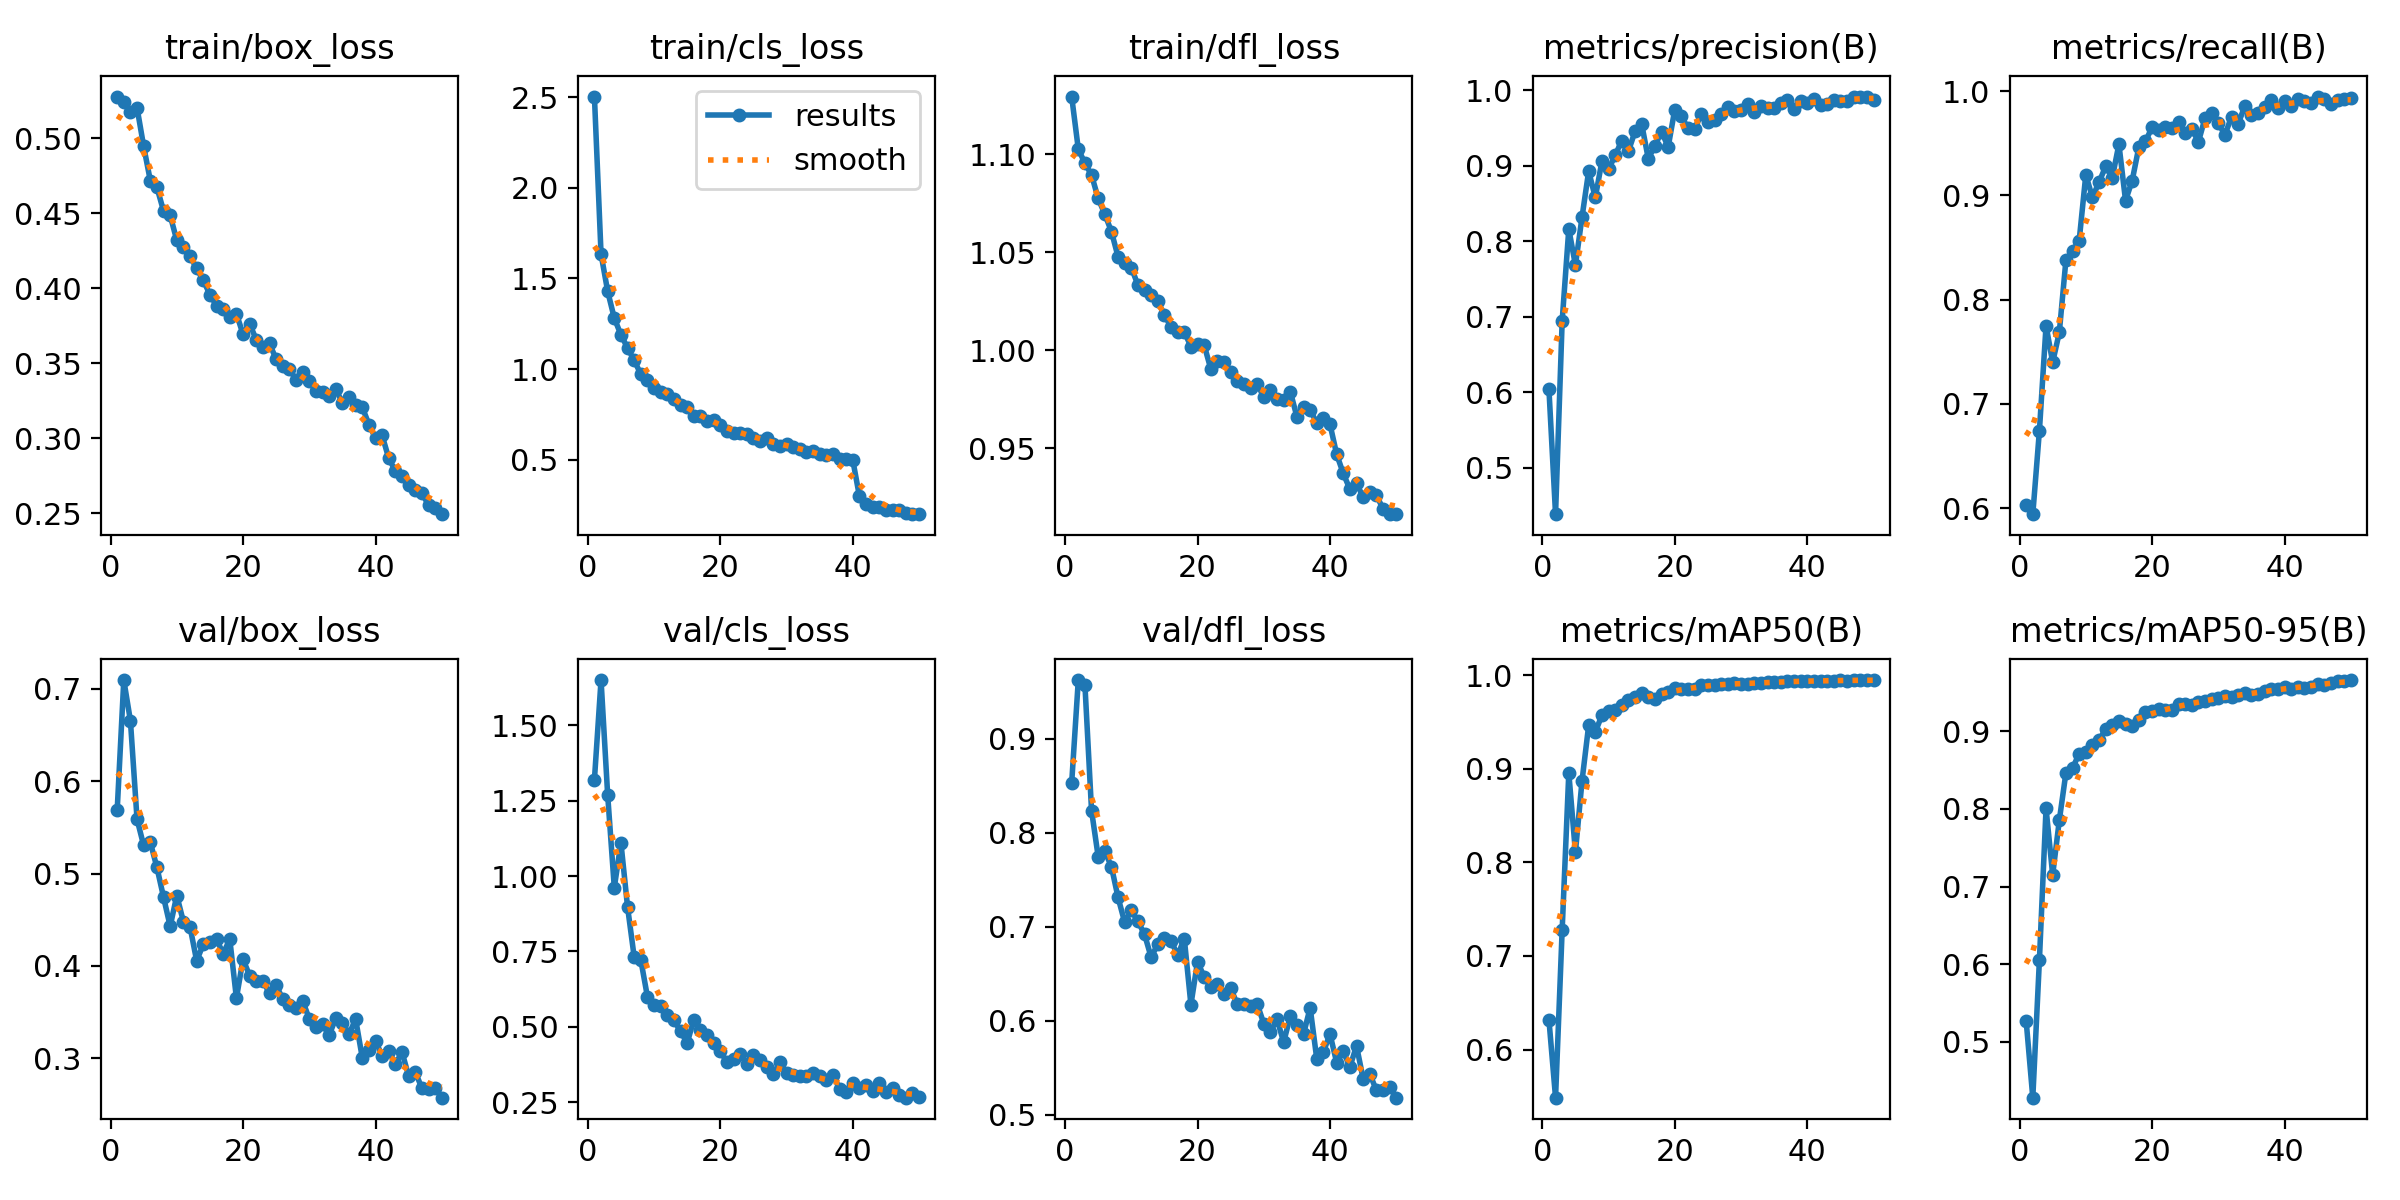

In [ ]:
display(Image(filename= output_dir/'results.png', width=1000))

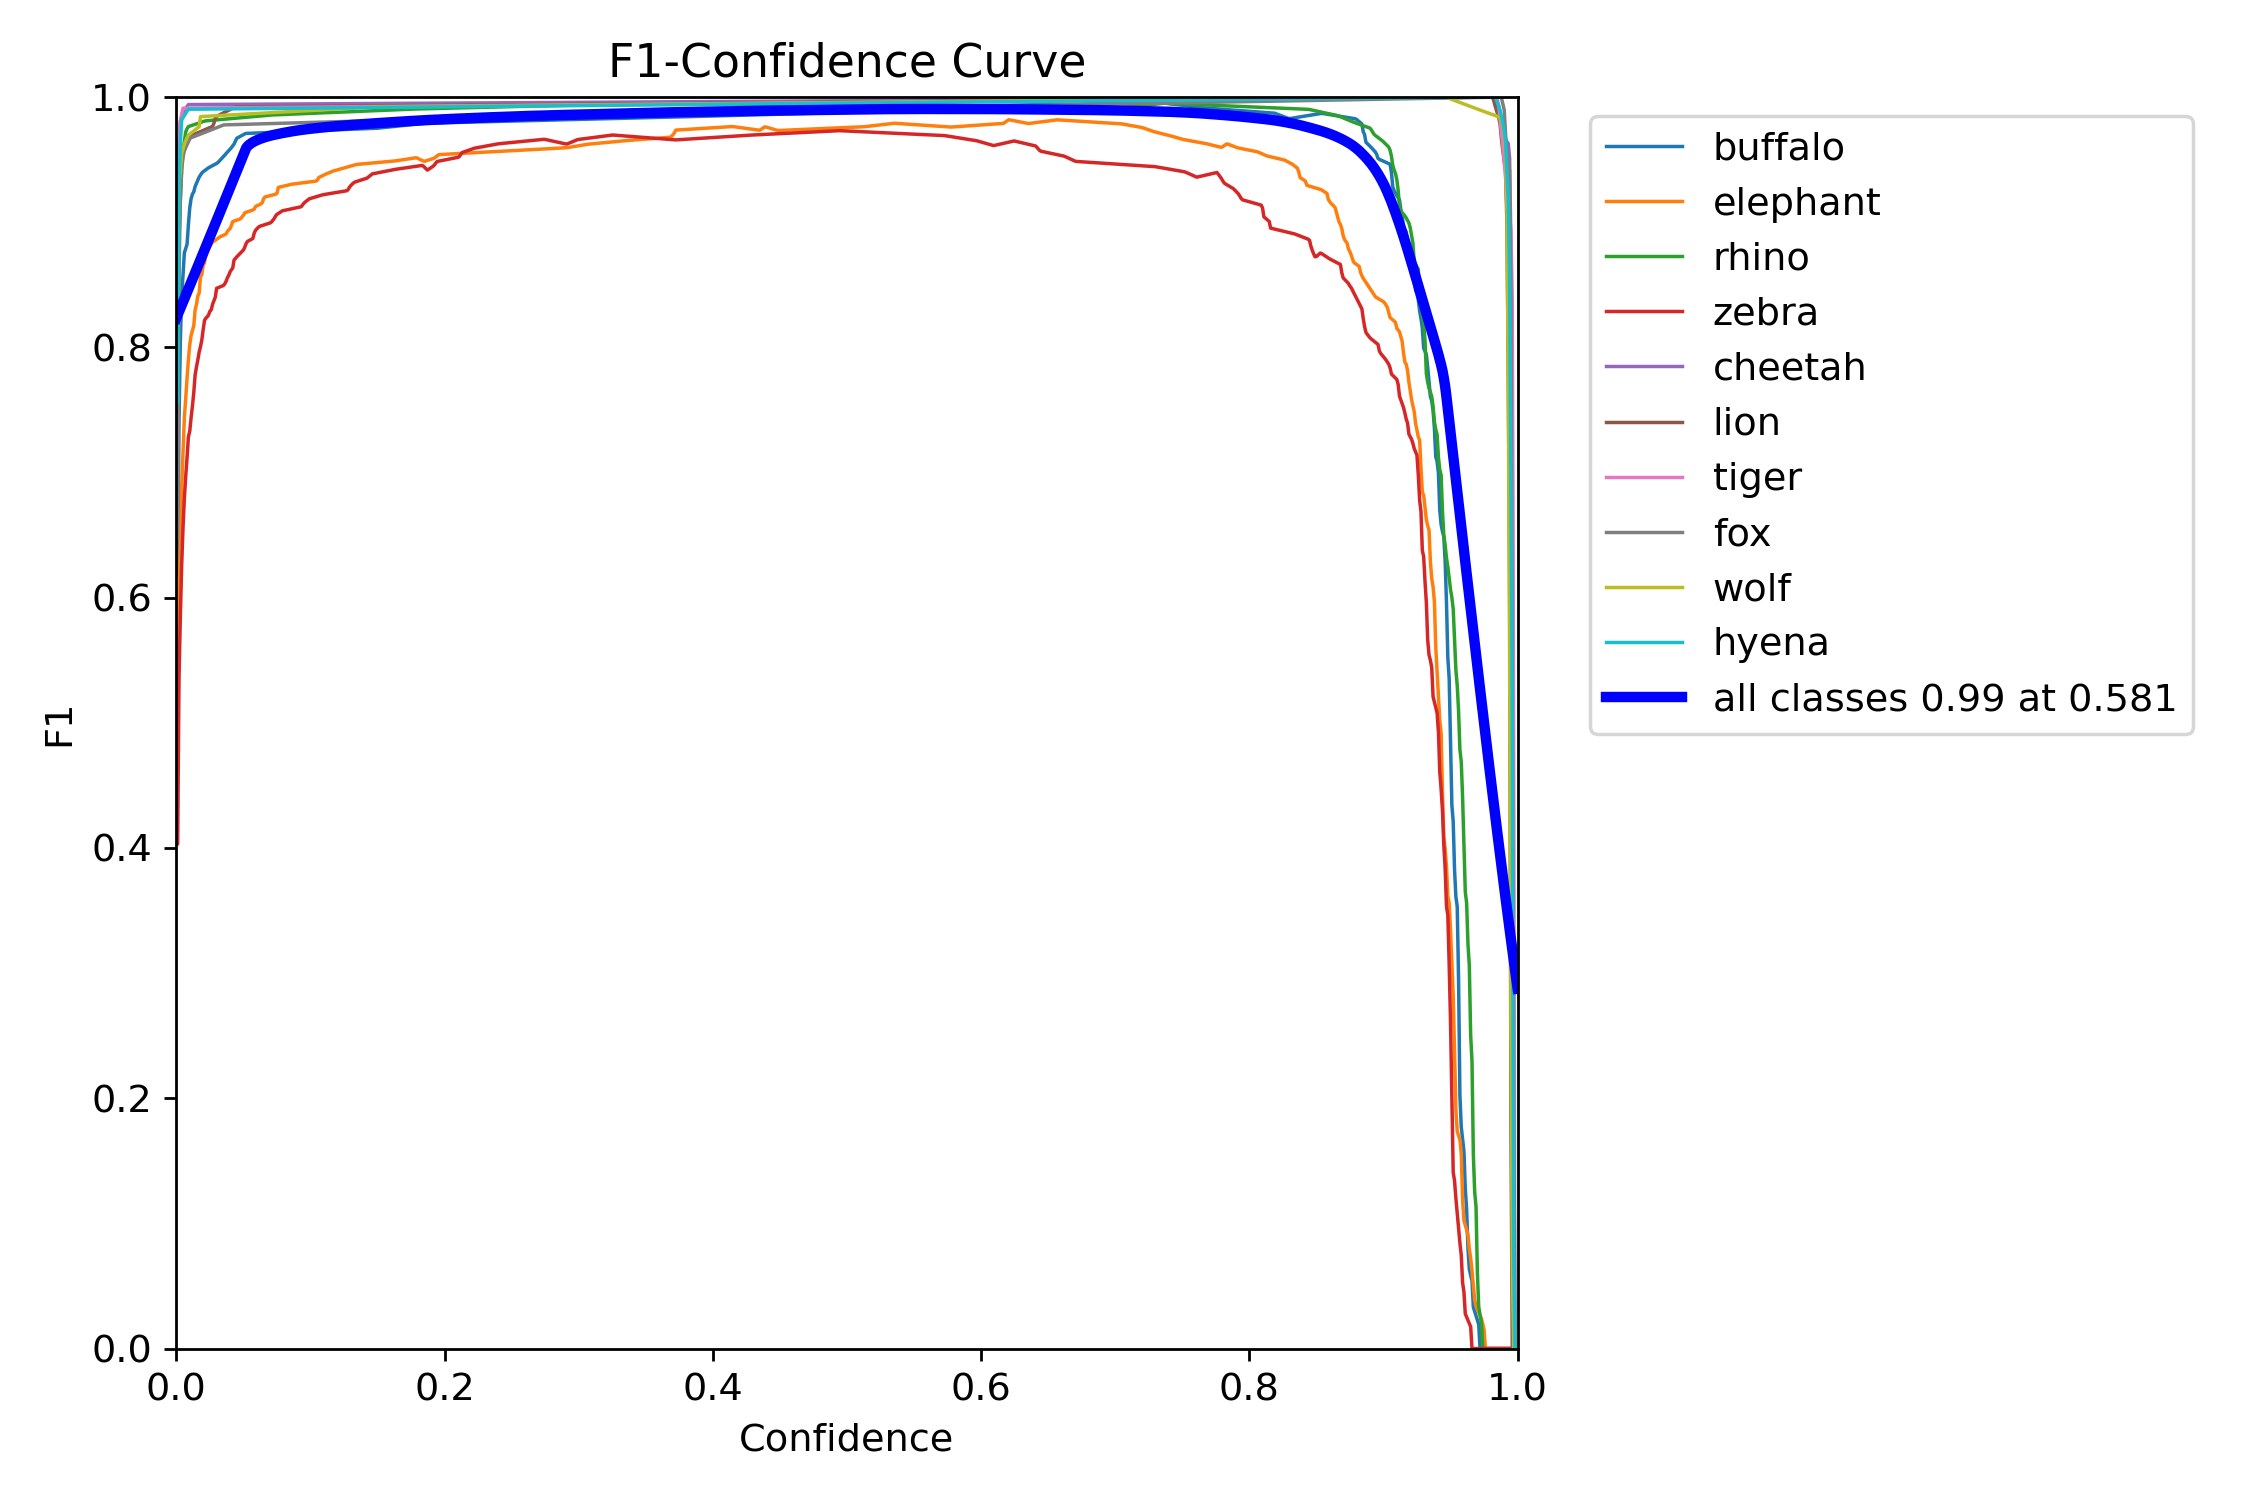

In [ ]:
display(Image(filename=output_dir/'F1_curve.png', width=1000))

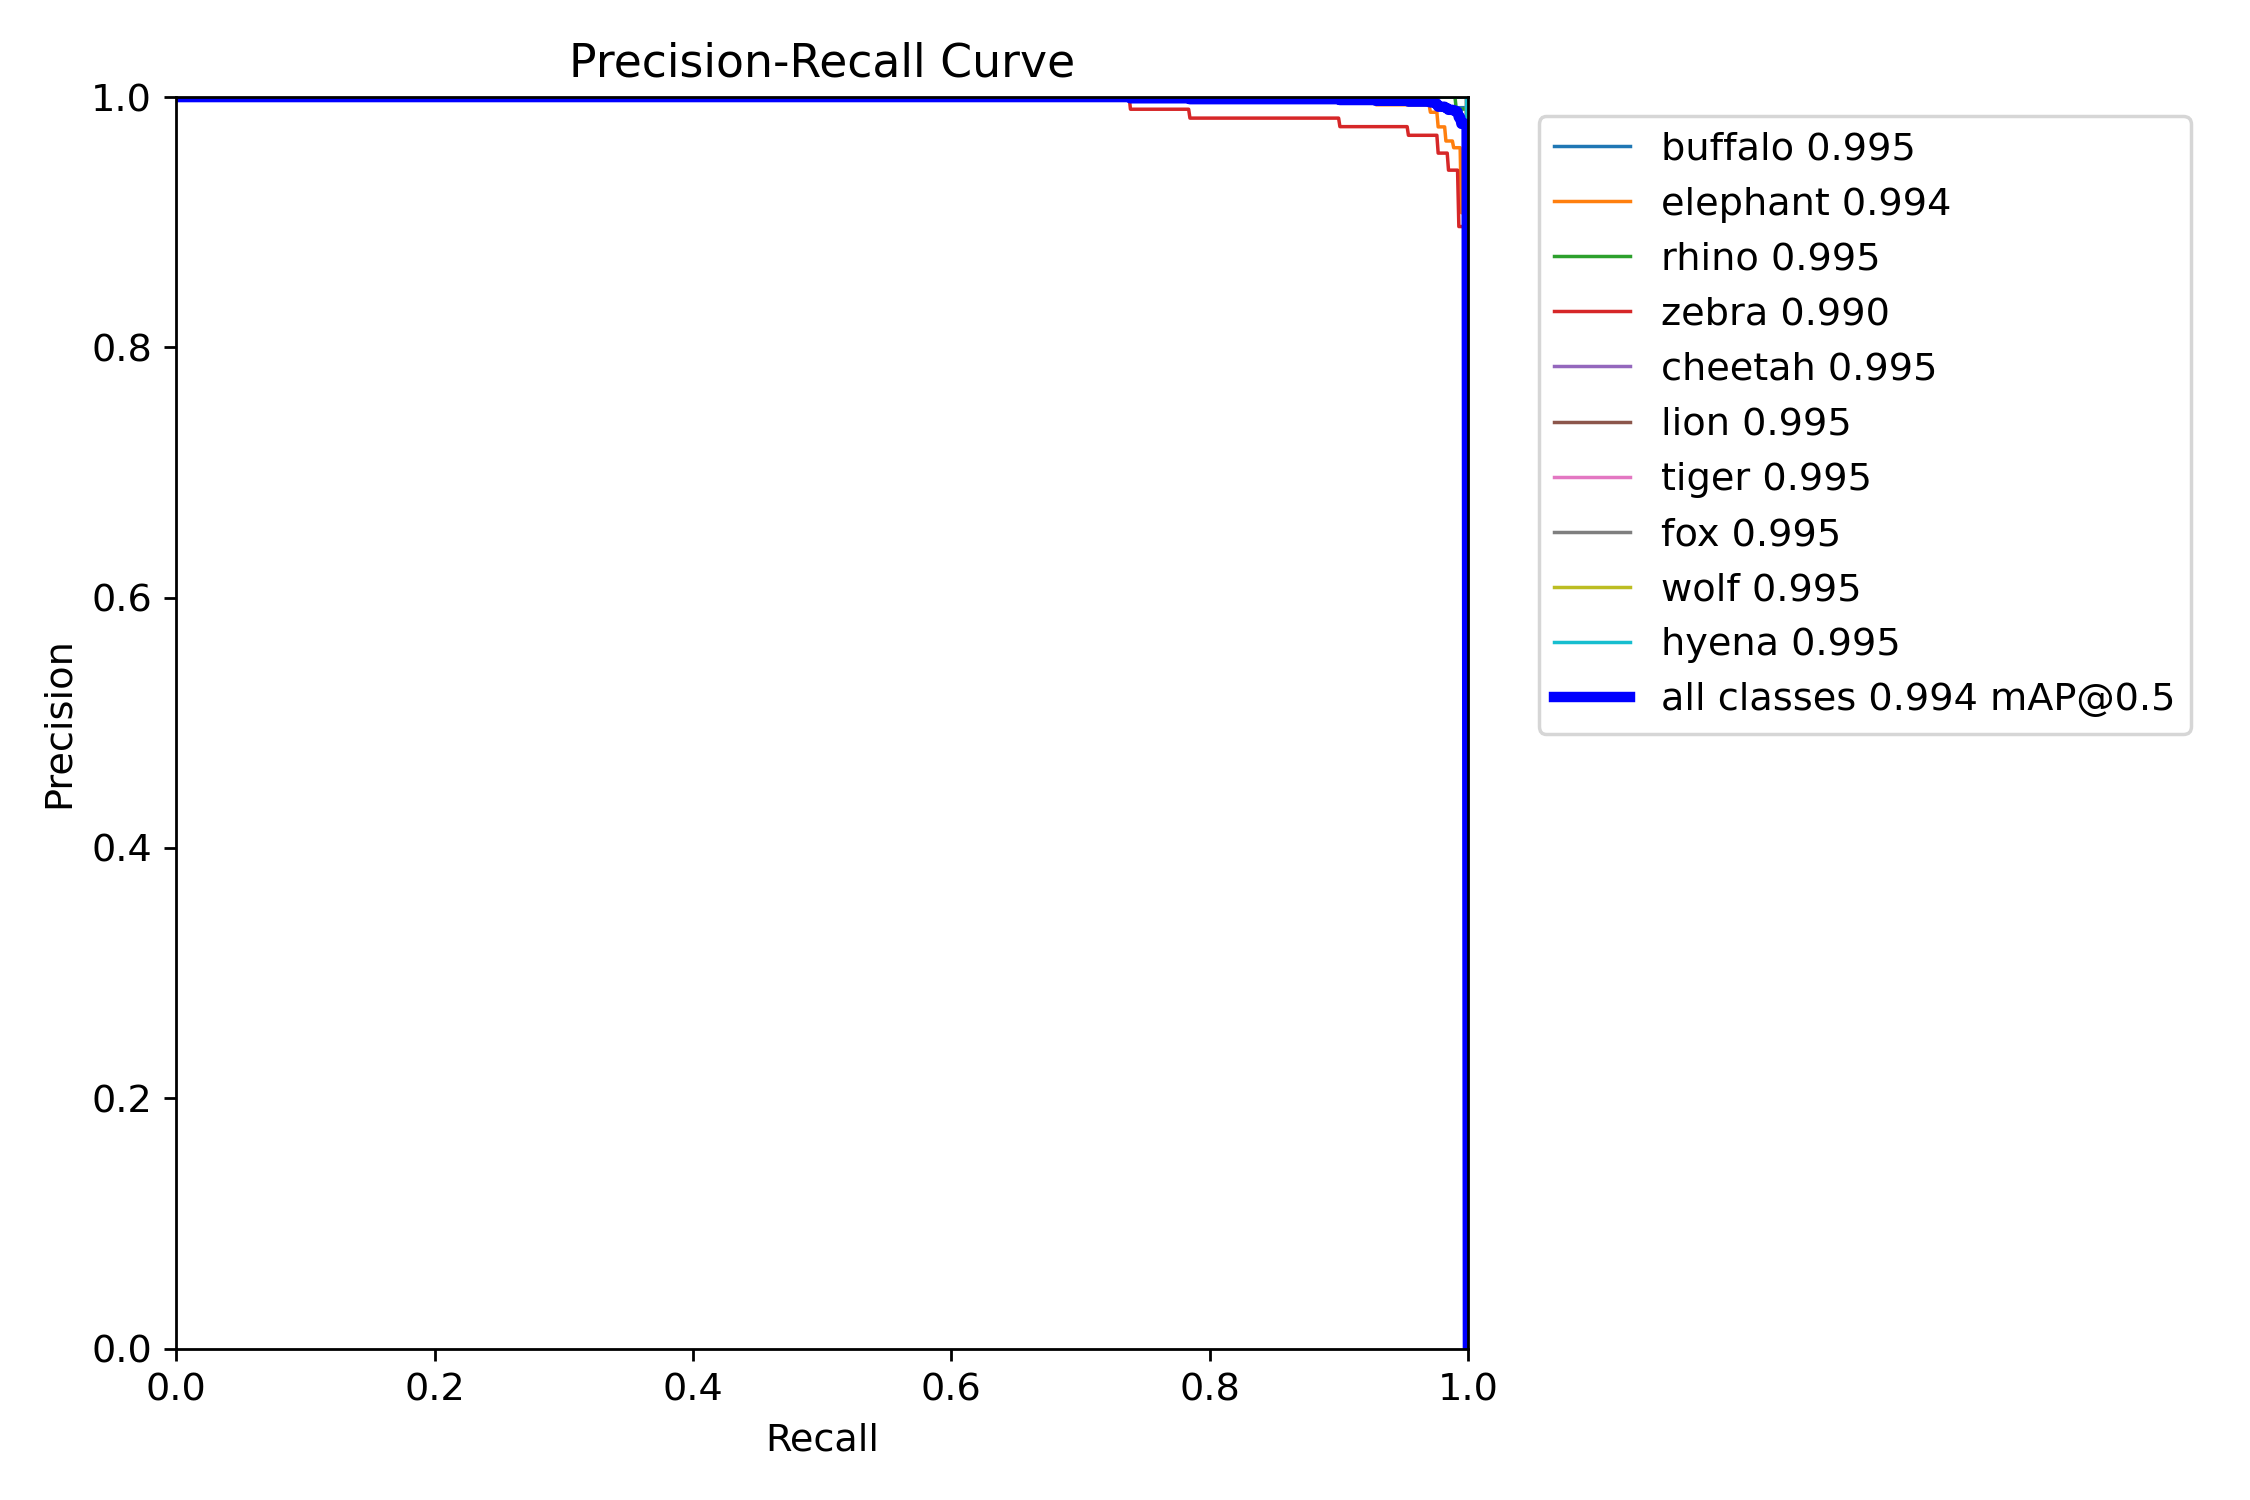

In [ ]:
display(Image(filename=output_dir/'PR_curve.png', width=1000))

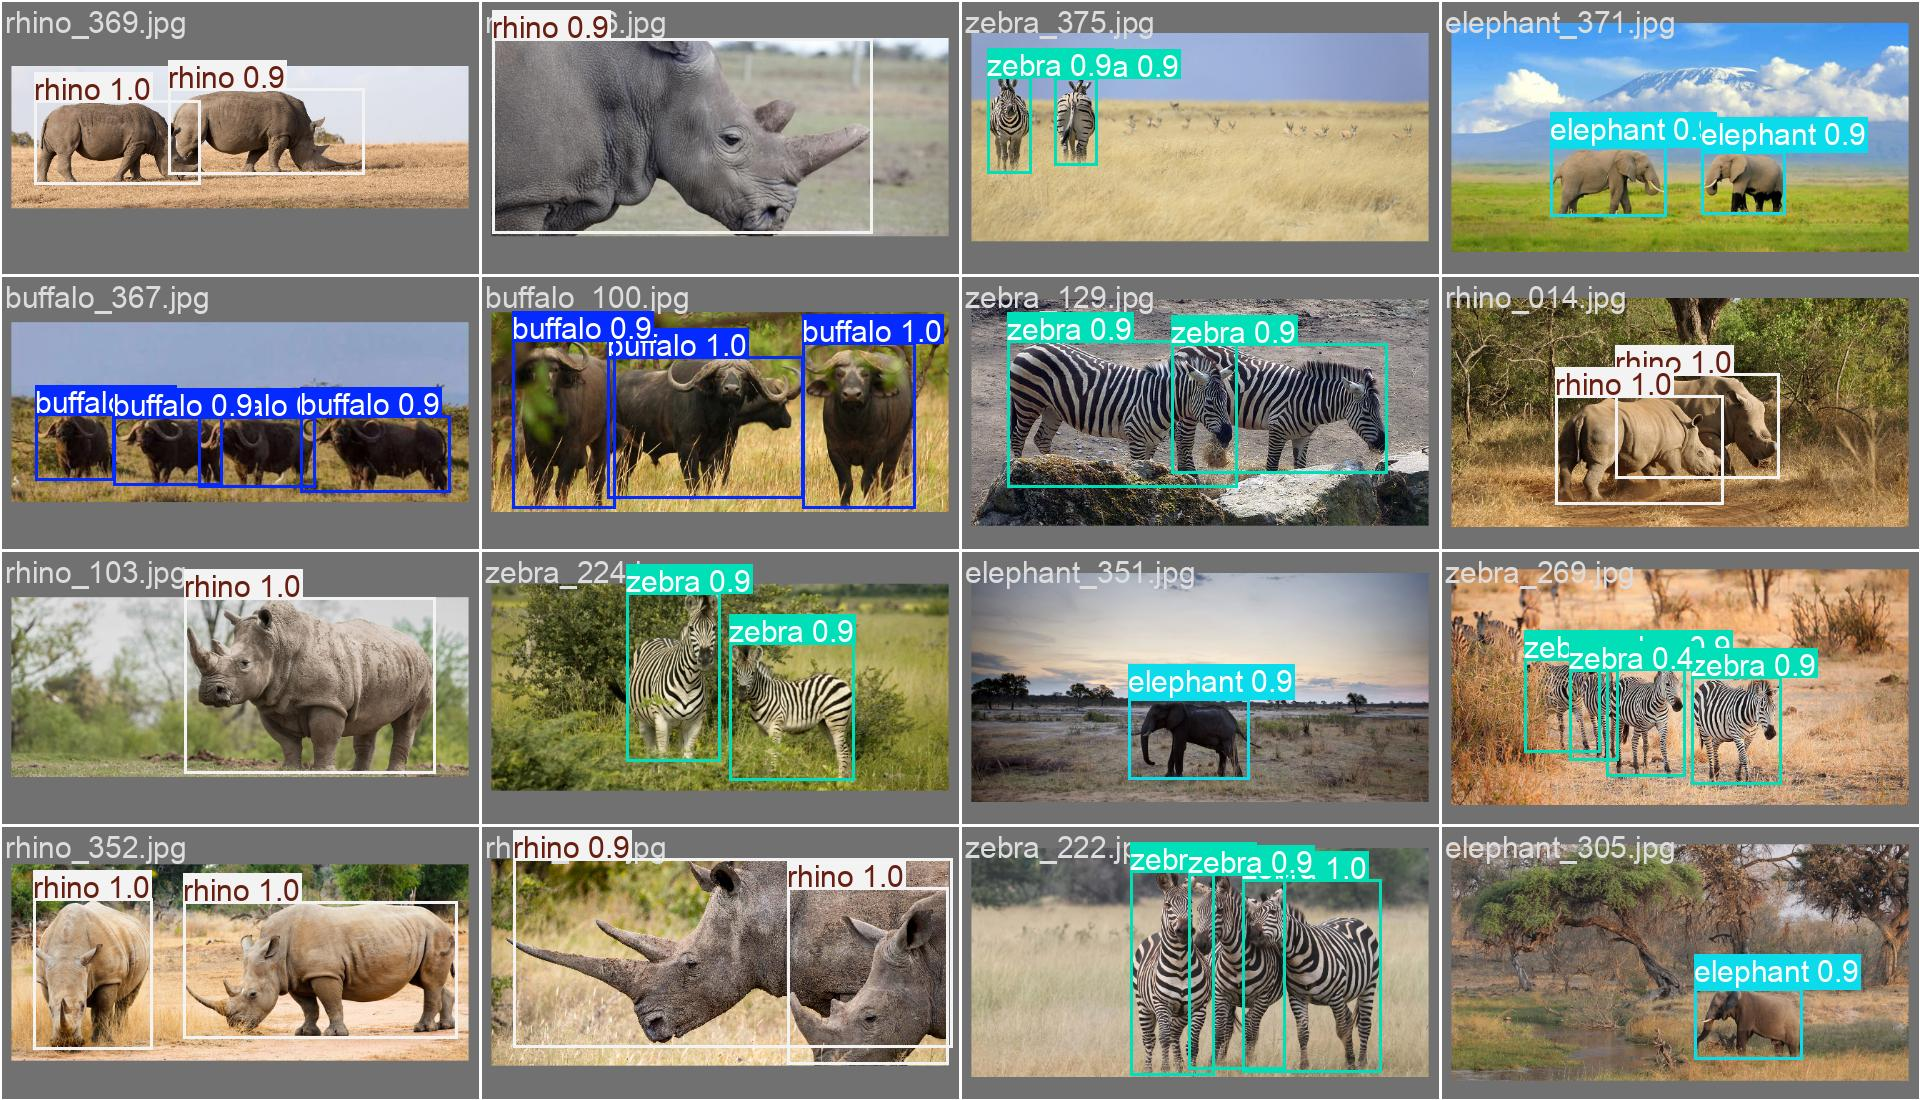

In [ ]:
display(Image(filename=output_dir/'val_batch0_pred.jpg', width=1000))

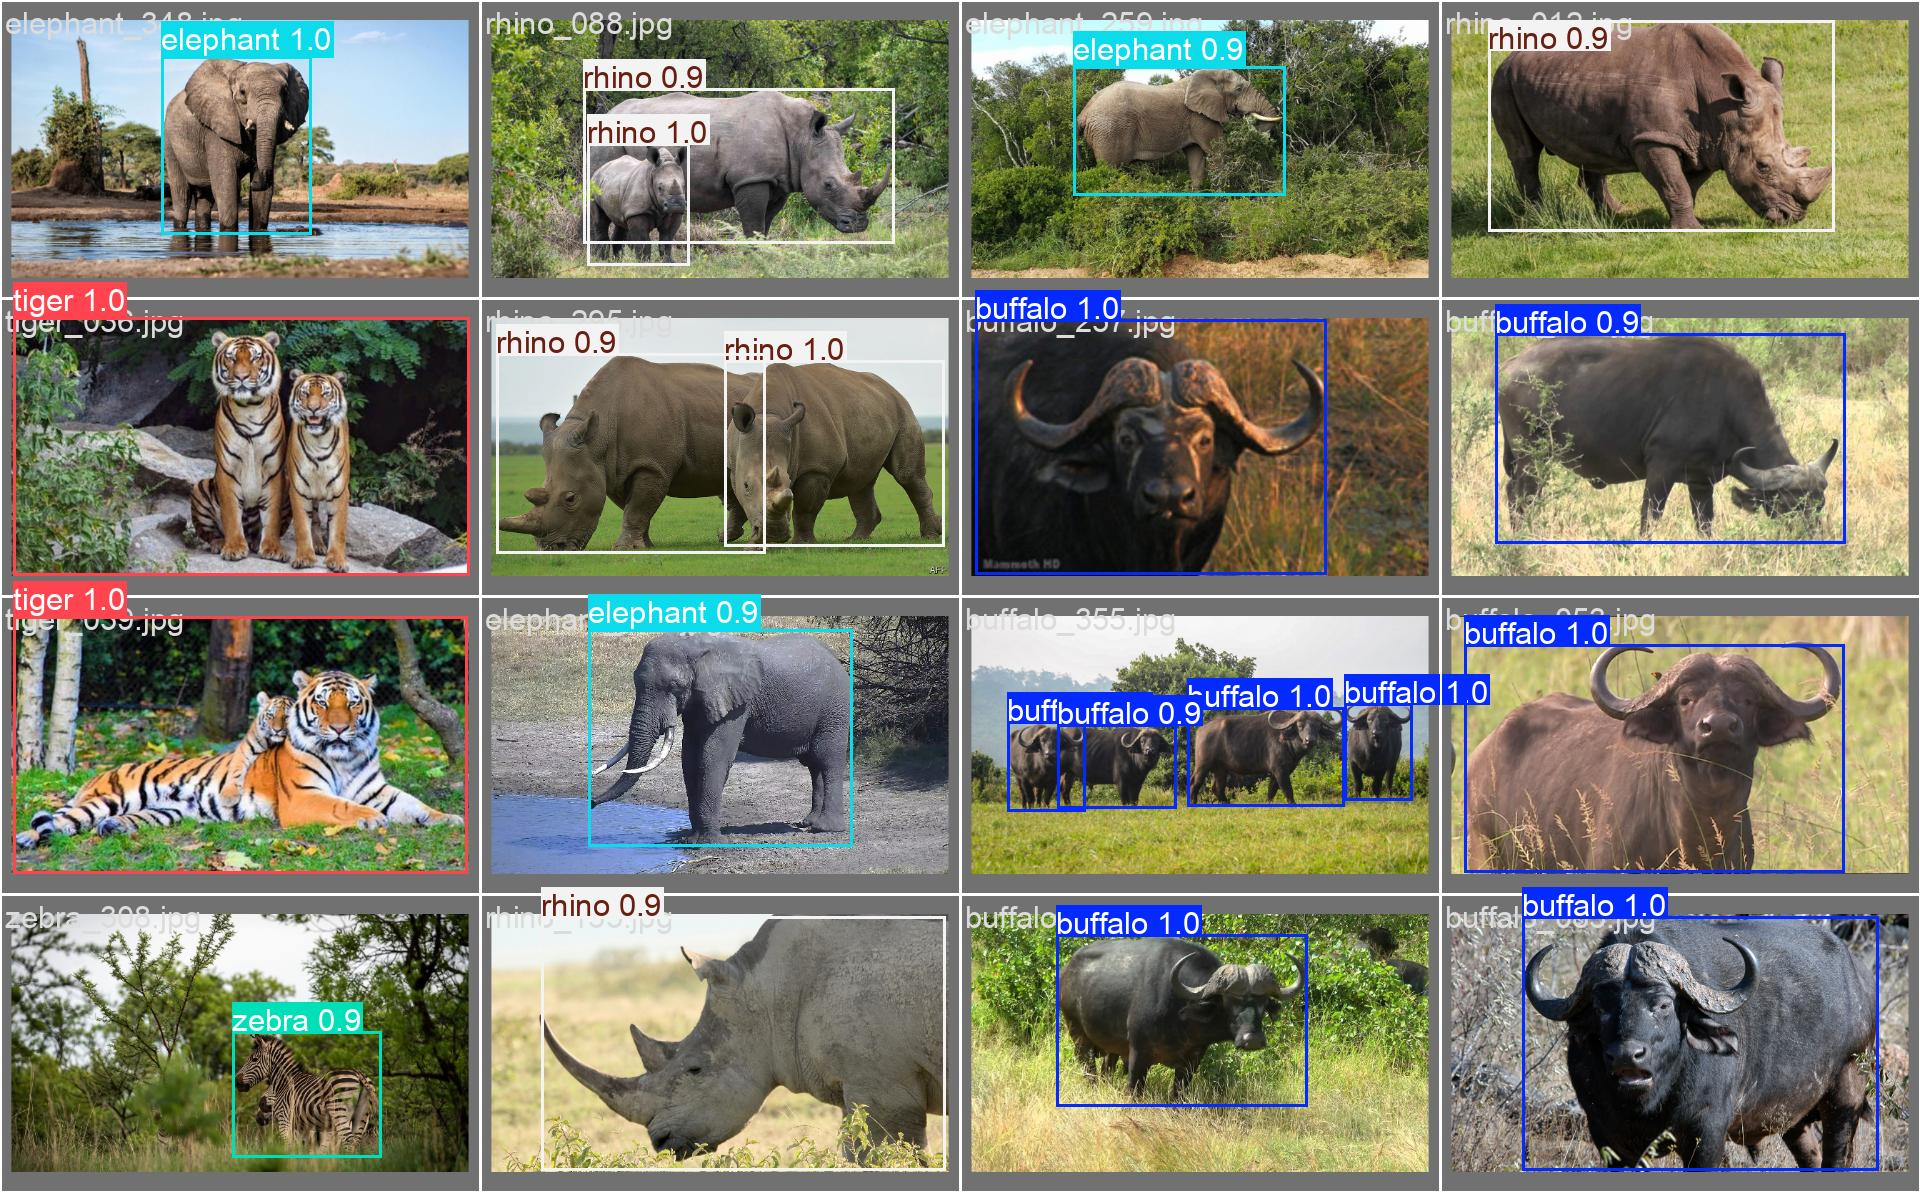

In [ ]:
display(Image(filename=output_dir/'val_batch1_pred.jpg', width=1000))

# Test

In [10]:
!yolo task=detect mode=val model=/content/drive/MyDrive/yolo-retrain1/detect/train4/weights/best.pt data=animal.yaml split=test

Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.8±0.2 ms, read: 0.1±0.0 MB/s, size: 60.1 KB)
val: Scanning /content/drive/.shortcut-targets-by-id/1f4tkq5ctTz4G4pB27BswNW8B8In4cwyr/yolo-data/labels/test... 326 images, 0 backgrounds, 0 corrupt: 100% 326/326 [02:29<00:00,  2.19it/s]
val: New cache created: /content/drive/.shortcut-targets-by-id/1f4tkq5ctTz4G4pB27BswNW8B8In4cwyr/yolo-data/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 21/21 [00:06<00:00,  3.04it/s]
                   all        326        463      0.983       0.98      0.993       0.96
               buffalo         39         63      0.976      0.937      0.993      0.934
              elephant         22         51      0.972          1      0.995      0.927
                 rhino         32         50       0

In [11]:
!ls 'runs/detect/val'

confusion_matrix_normalized.png  PR_curve.png		val_batch1_labels.jpg
confusion_matrix.png		 R_curve.png		val_batch1_pred.jpg
F1_curve.png			 val_batch0_labels.jpg	val_batch2_labels.jpg
P_curve.png			 val_batch0_pred.jpg	val_batch2_pred.jpg


In [12]:
!cp -r runs/detect/val /content/drive/MyDrive/yolo-test/

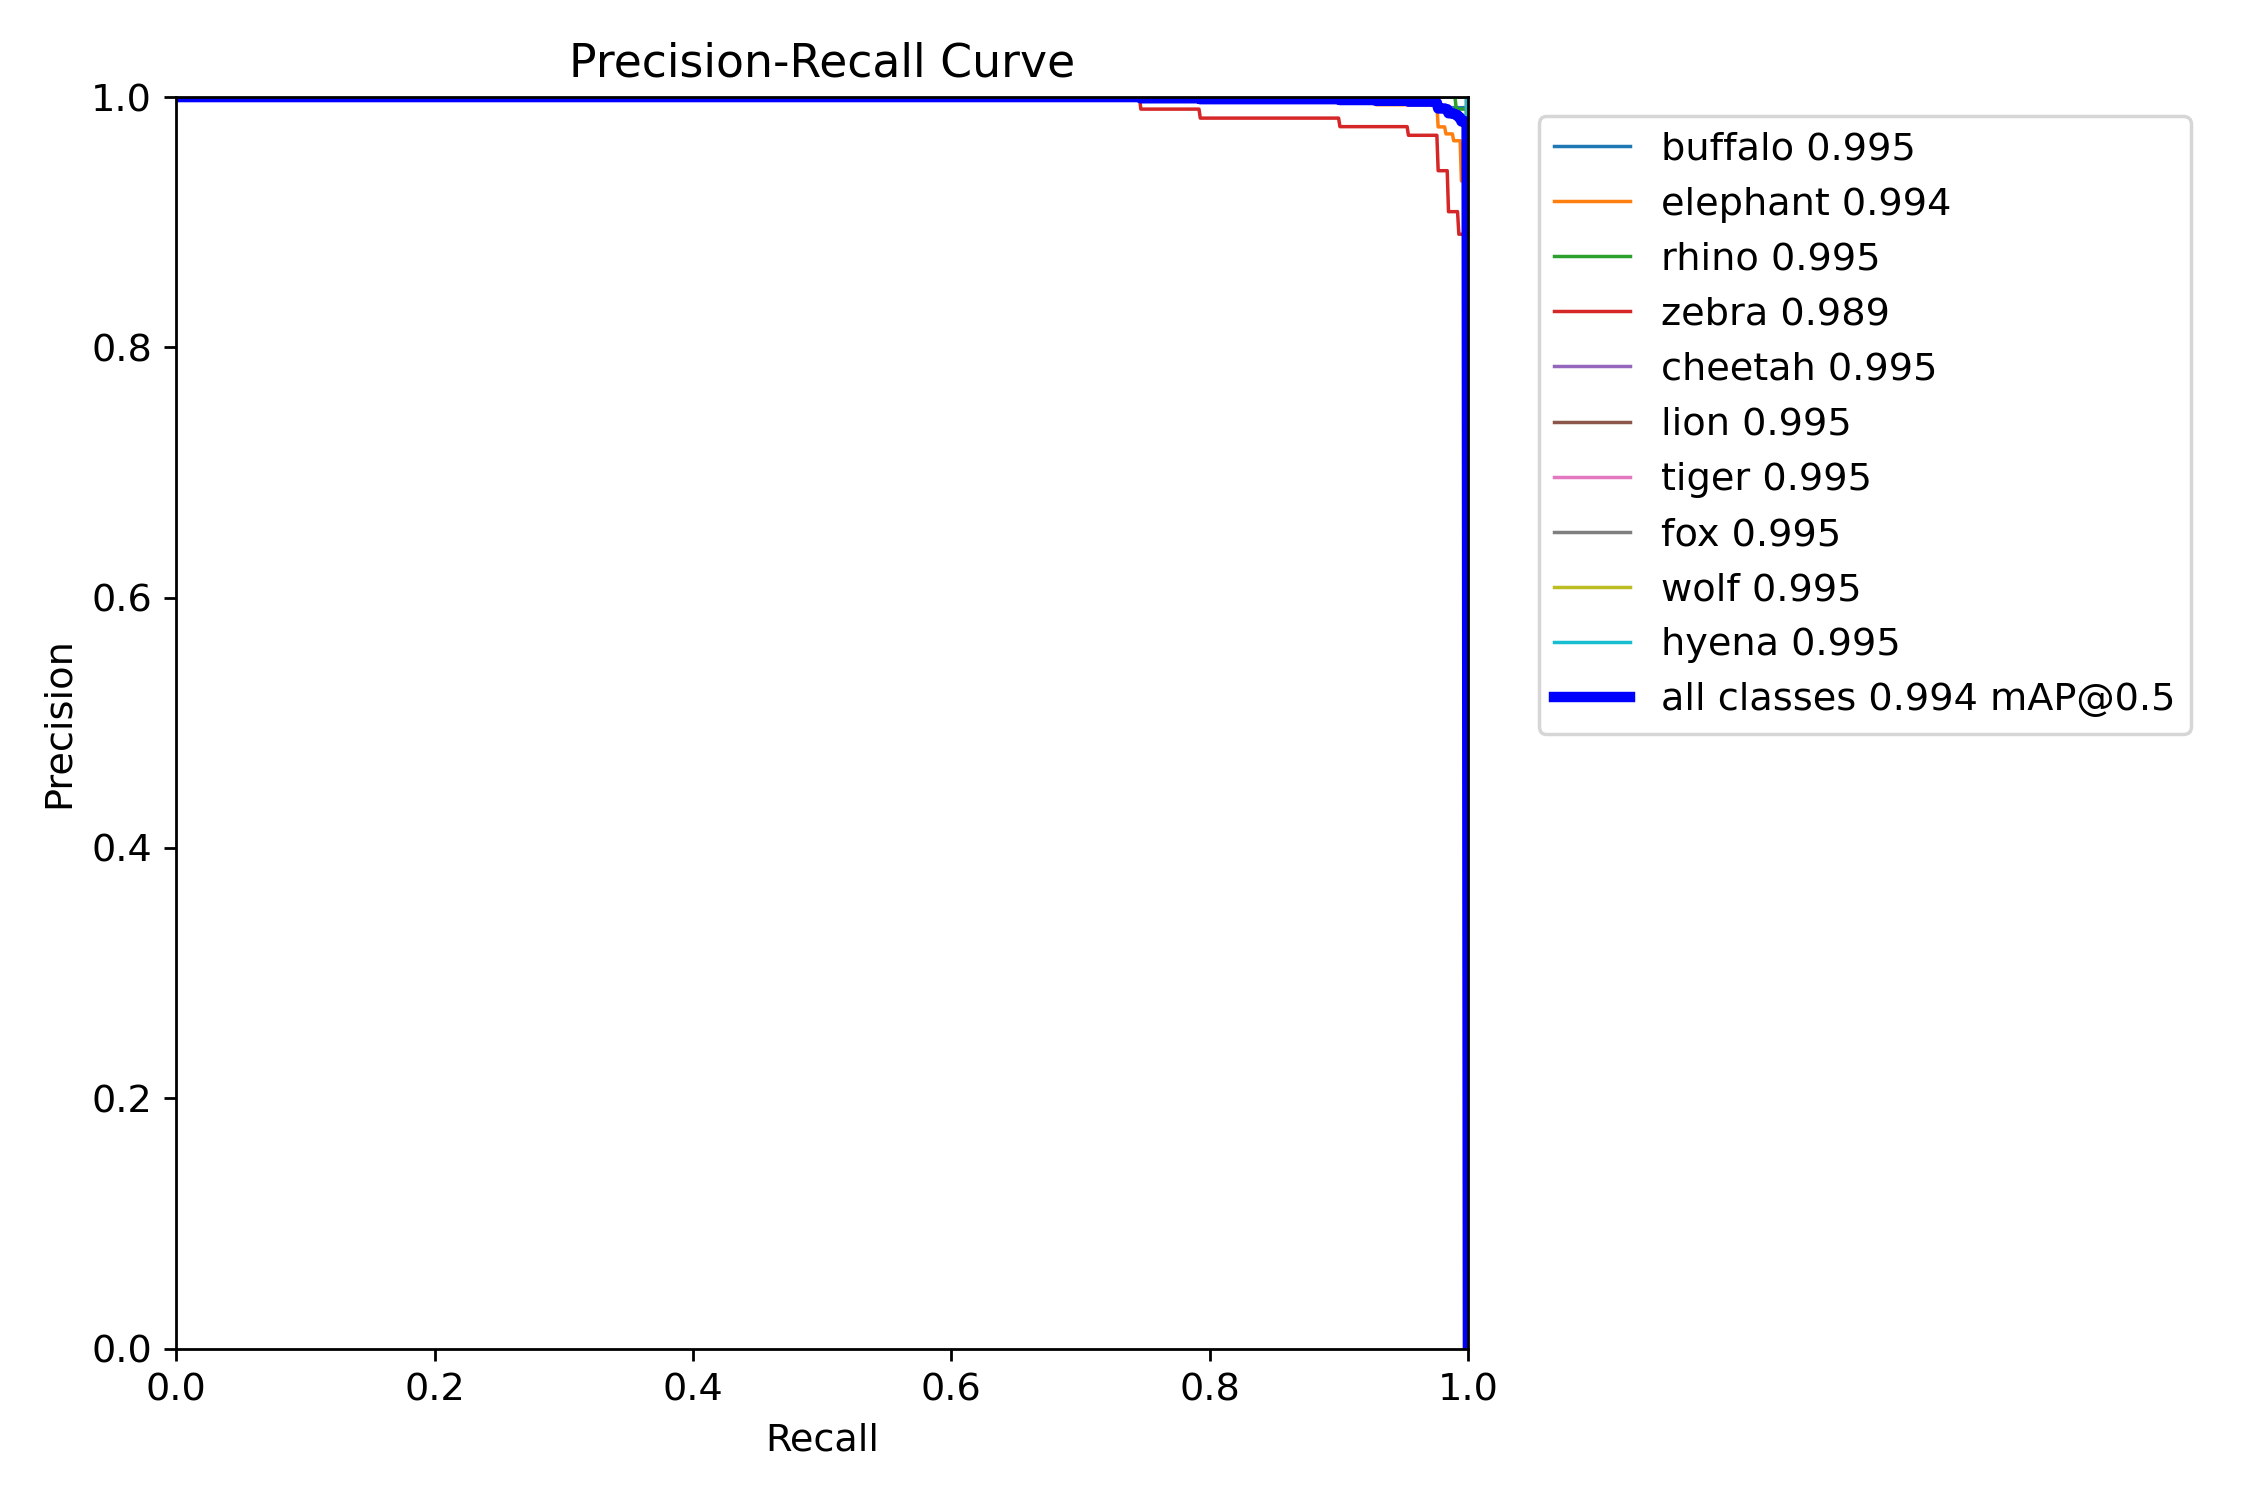

In [13]:
display(Image(filename="runs/detect/val/PR_curve.png", width=1000))

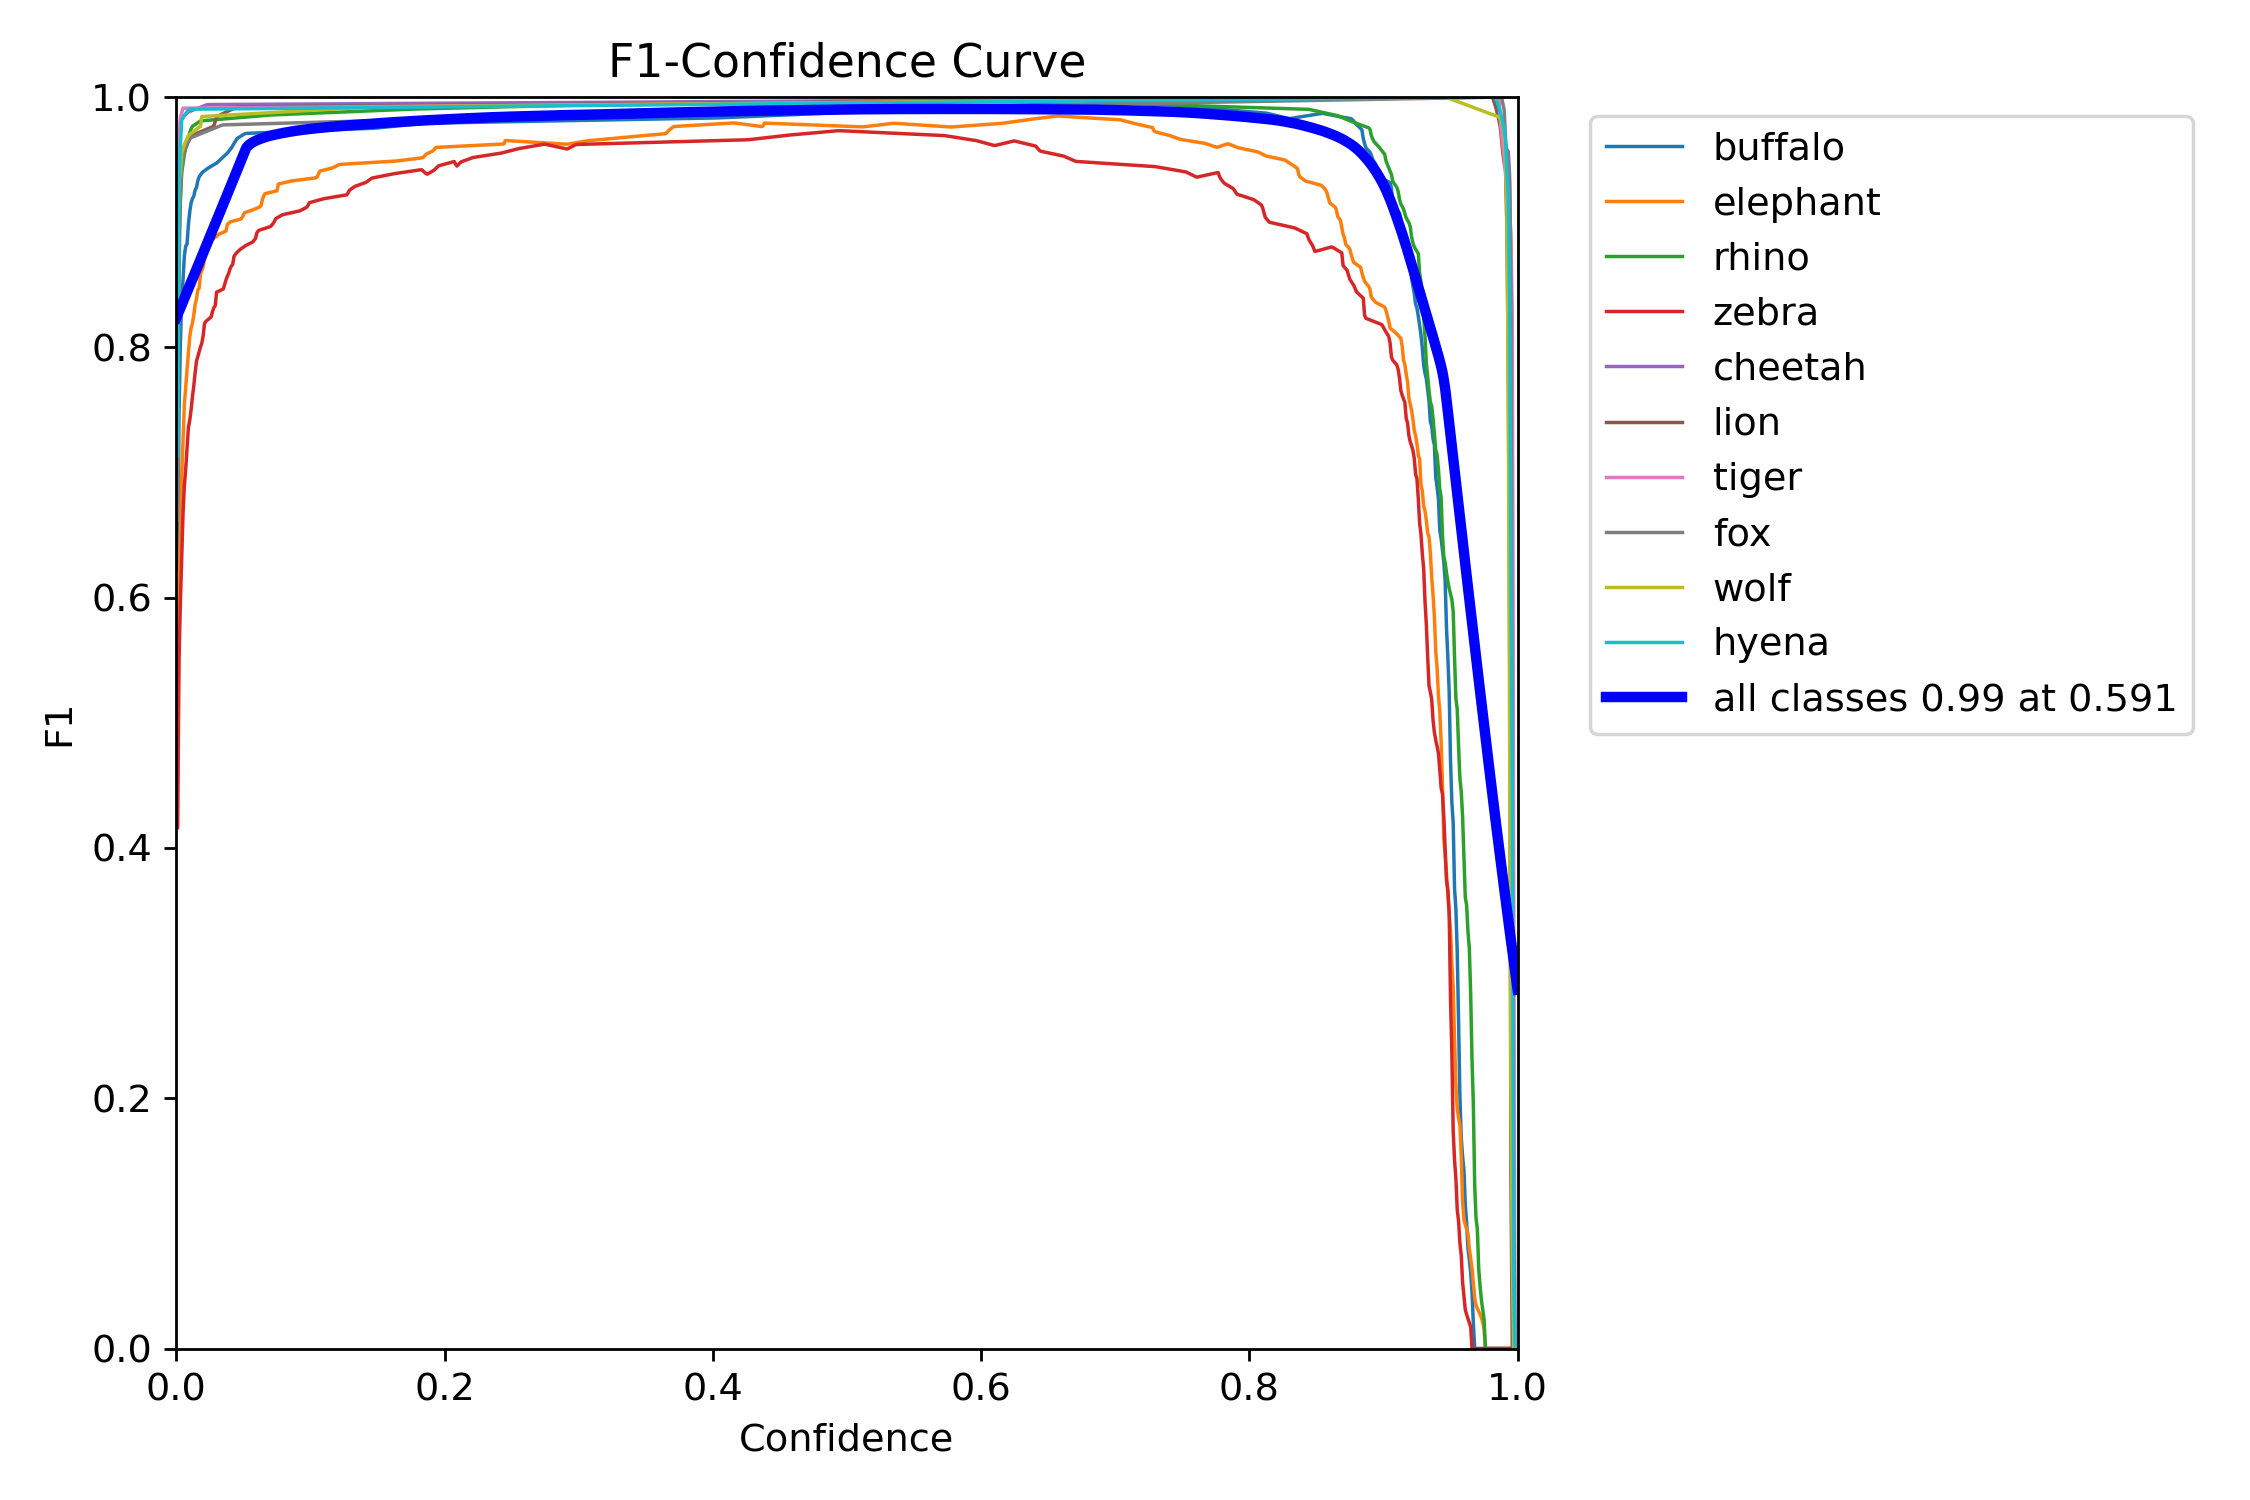

In [14]:
display(Image(filename="runs/detect/val/F1_curve.png", width=1000))

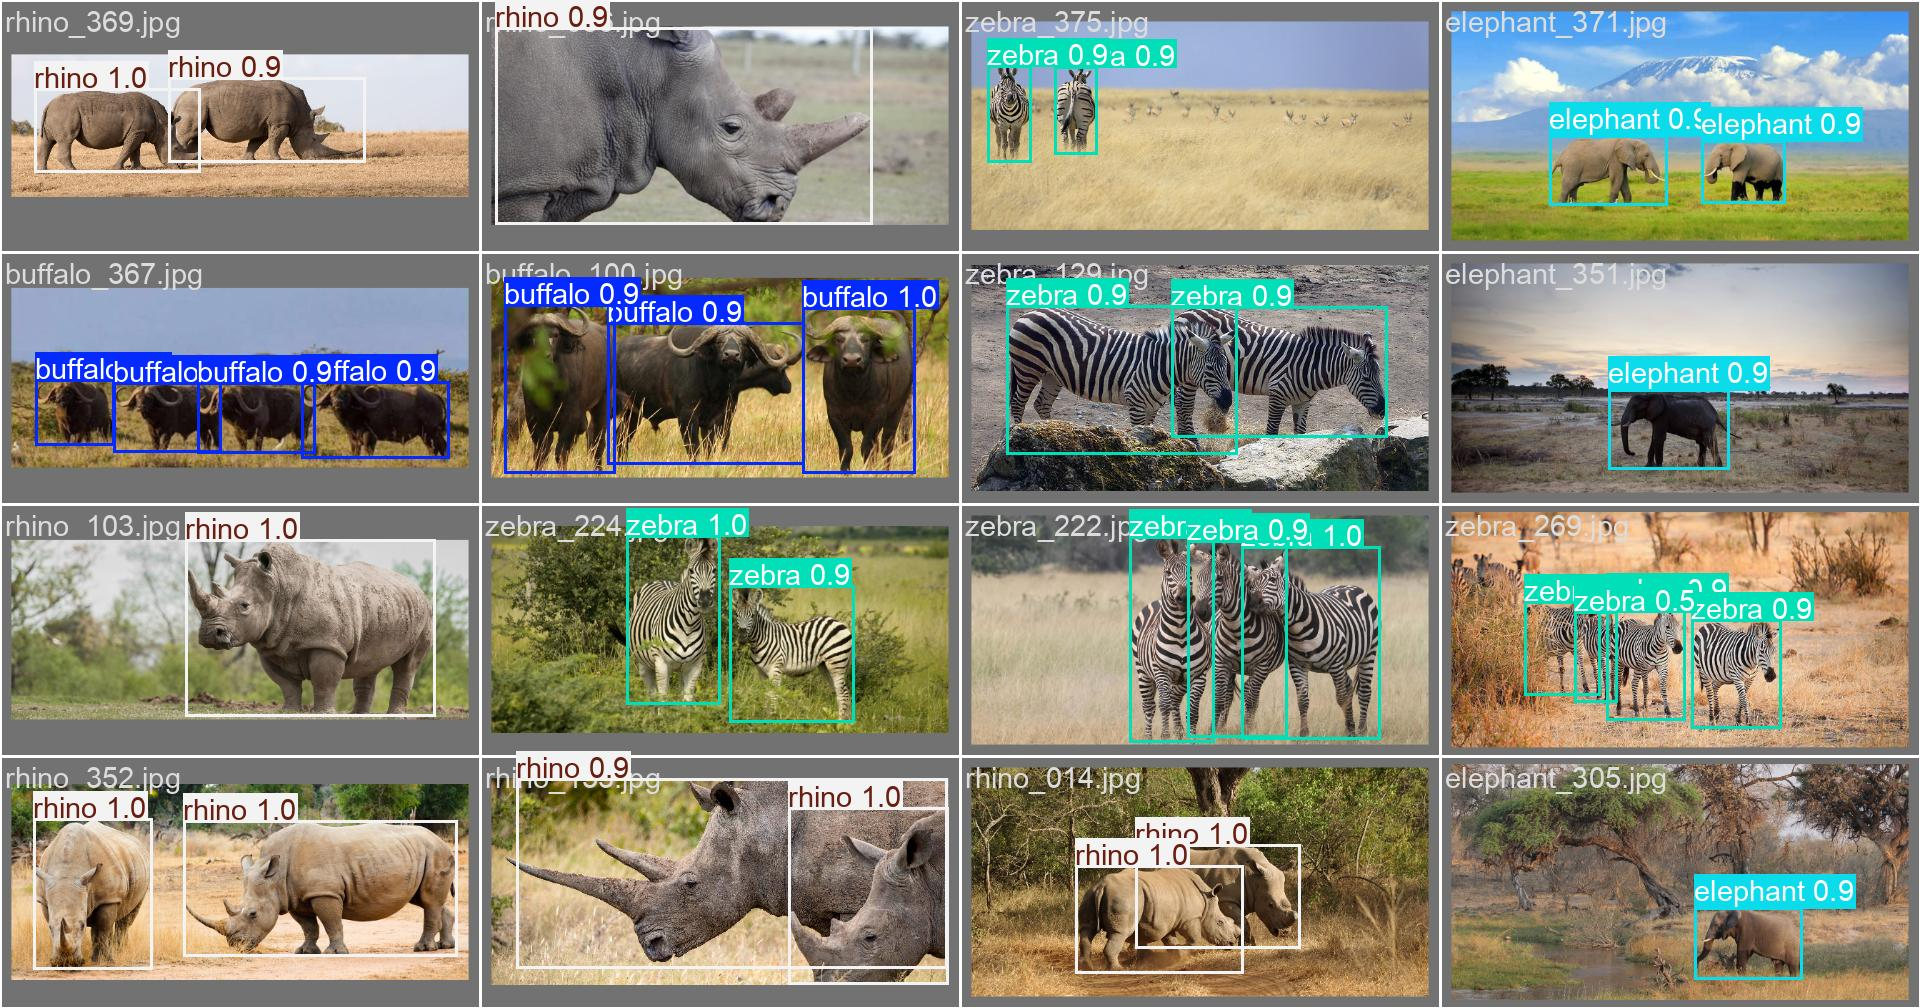

In [15]:
display(Image(filename="runs/detect/val/val_batch0_pred.jpg", width=1000))

# Inference

In [19]:
!yolo task=detect mode=predict model=/content/drive/MyDrive/yolo-retrain1/detect/train4/weights/best.pt conf=0.35 source=/content/drive/MyDrive/cv_project/test_images save=True

Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs

image 1/10 /content/drive/MyDrive/cv_project/test_images/buffalo.jpg: 448x640 1 buffalo, 36.7ms
image 2/10 /content/drive/MyDrive/cv_project/test_images/cheetah.jpg: 384x640 1 cheetah, 38.1ms
image 3/10 /content/drive/MyDrive/cv_project/test_images/elephant.jpg: 480x640 2 elephants, 33.4ms
image 4/10 /content/drive/MyDrive/cv_project/test_images/fox.jpg: 384x640 1 elephant, 7.0ms
image 5/10 /content/drive/MyDrive/cv_project/test_images/hyena.jpg: 448x640 1 wolf, 6.9ms
image 6/10 /content/drive/MyDrive/cv_project/test_images/lion.jpg: 448x640 1 lion, 8.0ms
image 7/10 /content/drive/MyDrive/cv_project/test_images/rhino.jpg: 480x640 1 rhino, 7.2ms
image 8/10 /content/drive/MyDrive/cv_project/test_images/tiger.jpg: 384x640 1 tiger, 6.8ms
image 9/10 /content/drive/MyDrive/cv_project/test_images/wolf.jpg: 480x640 1 wolf, 6.6ms
ima

In [21]:
import glob
img_path = glob.glob(f'./runs/detect/predict/*')

for img in img_path:
  display(Image(filename=img, width=500))
  print('\n')

Output hidden; open in https://colab.research.google.com to view.